In [16]:
# ============================================================
# CNN Baseline (GAF-Only) with 5-Fold Stratified Cross-Validation
# ============================================================
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, accuracy_score,
                             precision_score, recall_score, f1_score)
import matplotlib.pyplot as plt
import random


In [17]:
# ---------------------------
# 0. Reproducibility & Device
# ---------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [18]:
# ---------------------------
# 1. Load Data (from .npy)
# ---------------------------
gaf_images = np.load("gaf_images2.npy")   # (N, 64, 64)
labels = np.load("y_train_all.npy")       # (N,)

assert len(gaf_images) == len(labels), "Jumlah sampel gambar & label harus sama."
num_classes = len(np.unique(labels))
print("Data shape:", gaf_images.shape, "Classes:", np.unique(labels))

# Optional: simple scaling to [0,1] if data not already scaled
# (Jika GAF sudah dalam [-1,1] atau [0,1], ini aman.)
if gaf_images.max() > 1.0 or gaf_images.min() < 0.0:
    gmax = gaf_images.max()
    gmin = gaf_images.min()
    if gmax != gmin:
        gaf_images = (gaf_images - gmin) / (gmax - gmin)


Data shape: (22400, 64, 64) Classes: [0 1 2 3]


In [19]:
# ---------------------------
# 2. Dataset & Dataloader
# ---------------------------
class GAFImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images.astype(np.float32)
        self.labels = labels.astype(np.int64)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]  # (64, 64)
        # Add channel dimension => (1, 64, 64)
        img = np.expand_dims(img, axis=0)
        img = torch.from_numpy(img)  # float32
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label


In [20]:
# ---------------------------
# 3. Model: Simple CNN Baseline
#    (3 Conv blocks + GAP + FC)
# ---------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4, in_ch=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_ch, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 64->32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 32->16
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 16->8
        )
        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)  # -> (128, 1, 1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)    # (B,32,32,32)
        x = self.conv2(x)    # (B,64,16,16)
        x = self.conv3(x)    # (B,128,8,8)
        x = self.gap(x)      # (B,128,1,1)
        x = x.view(x.size(0), -1)  # (B,128)
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [21]:
# ---------------------------
# 4. Training Utilities
# ---------------------------
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

@torch.no_grad()
def eval_one_epoch(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_y_true, all_y_pred = [], []
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)
        running_loss += loss.item() * labels.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_y_true.extend(labels.cpu().numpy())
        all_y_pred.extend(preds.cpu().numpy())
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, np.array(all_y_true), np.array(all_y_pred)

def ensure_dir(p):
    os.makedirs(p, exist_ok=True)


In [22]:
# ---------------------------
# 5. Cross-Validation Config
# ---------------------------
BATCH_SIZE = 128
EPOCHS = 20
LR = 1e-3
WEIGHT_DECAY = 1e-4
N_FOLDS = 5
class_names = ["N", "S", "V", "Q"][:num_classes]  # adapt to #classes

out_dir = "cnn_non_tuning"
ensure_dir(out_dir)

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

# Metrik agregasi
fold_metrics = []         # Ringkasan per fold (accuracy, precision, recall/sensitivity, specificity, f1)
per_class_metrics = []    # Per kelas, per fold (precision, sensitivity/recall, specificity, f1)


In [24]:
# ---------------------------
# 6. Run K-Fold Training
# ---------------------------
X = gaf_images
y = labels

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n========== Fold {fold+1}/{N_FOLDS} ==========")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    train_ds = GAFImageDataset(X_train, y_train)
    val_ds   = GAFImageDataset(X_val, y_val)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    model = SimpleCNN(num_classes=num_classes, in_ch=1).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_acc = -1.0
    best_state = None

    for epoch in range(1, EPOCHS+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc, y_true_ep, y_pred_ep = eval_one_epoch(model, val_loader, criterion)

        train_losses.append(tr_loss)
        val_losses.append(val_loss)
        train_accuracies.append(tr_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch:02d}/{EPOCHS} | "
              f"Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # simpan best untuk fold ini (berdasar val acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict().copy()

    # restore best & simpan model fold
    model.load_state_dict(best_state)
    torch.save(model.state_dict(), os.path.join(out_dir, f"cnn_fold{fold+1}.pth"))
    print(f"✅ Model saved: {os.path.join(out_dir, f'cnn_fold{fold+1}.pth')}")

    # ------------- Evaluasi final per fold (pakai best model) -------------
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels_b in val_loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels_b.numpy())

    # Report & Confusion Matrix
    report = classification_report(y_true, y_pred, output_dict=True,
                                   target_names=class_names, zero_division=0)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

    # Specificity per-class: TN / (TN + FP)
    cm_sum = cm.sum()
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm_sum - (TP + FP + FN)
    specificity_per_class = TN / (TN + FP + 1e-8)

    # Simpan metrik per kelas
    for i, cname in enumerate(class_names):
        per_class_metrics.append({
            "Fold": f"Fold {fold+1}",
            "Class": cname,
            "Precision": report[cname]["precision"],
            "Sensitivity": report[cname]["recall"],
            "Specificity": specificity_per_class[i],
            "F1-Score": report[cname]["f1-score"]
        })

    # Metrik ringkasan per fold (weighted)
    fold_summary = {
        "Fold": fold+1,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="weighted", zero_division=0),
        "Sensitivity": recall_score(y_true, y_pred, average="weighted", zero_division=0),
        "Specificity": specificity_per_class.mean(),
        "F1-Score": f1_score(y_true, y_pred, average="weighted", zero_division=0)
    }
    fold_metrics.append(fold_summary)

    # ----------------- Simpan visual (per fold) -----------------
    # Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(5.5, 5))
    disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format="d")
    plt.title(f"Confusion Matrix CNN - Fold {fold+1}")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"cnn_confusion_matrix_fold{fold+1}.png"))
    plt.close(fig)

    # Accuracy curve
    plt.figure()
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.title(f"Training and Validation Accuracy - Fold {fold+1}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"cnn_accuracy_fold{fold+1}.png"))
    plt.close()

    # Loss curve
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title(f"Training and Validation Loss - Fold {fold+1}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"cnn_loss_fold{fold+1}.png"))
    plt.close()

# ---------------------------
# 7. Simpan Tabel (Per Kelas & Ringkasan Per Fold + Average)
# ---------------------------
df_per_class = pd.DataFrame(per_class_metrics)
df_per_class.to_csv(os.path.join(out_dir, "cnn_non_tuning_table5_per_class_metrics.csv"), index=False)

df_fold = pd.DataFrame(fold_metrics)
avg_metrics = df_fold[["Accuracy","Precision","Sensitivity","Specificity","F1-Score"]].mean(numeric_only=True)
avg_row = {"Fold": "Average"}
avg_row.update({k: float(v) for k, v in avg_metrics.to_dict().items()})
df_fold = pd.concat([df_fold, pd.DataFrame([avg_row])], ignore_index=True)
df_fold.to_csv(os.path.join(out_dir, "cnn_non_tuning_table3_4_fold_summary_metrics.csv"), index=False)

print("\n✅ Semua model, grafik, dan metrik CNN baseline disimpan di folder:", out_dir)


========== Fold 1/5 ==========
Epoch 01/20 | Train Loss: 0.4150 Acc: 0.8688 | Val Loss: 0.2650 Acc: 0.9150
Epoch 02/20 | Train Loss: 0.2301 Acc: 0.9272 | Val Loss: 0.7041 Acc: 0.7475
Epoch 03/20 | Train Loss: 0.1928 Acc: 0.9397 | Val Loss: 0.4881 Acc: 0.8239
Epoch 04/20 | Train Loss: 0.1762 Acc: 0.9431 | Val Loss: 0.2691 Acc: 0.9174
Epoch 05/20 | Train Loss: 0.1657 Acc: 0.9463 | Val Loss: 0.2162 Acc: 0.9281
Epoch 06/20 | Train Loss: 0.1535 Acc: 0.9490 | Val Loss: 0.1447 Acc: 0.9538
Epoch 07/20 | Train Loss: 0.1457 Acc: 0.9528 | Val Loss: 0.1803 Acc: 0.9413
Epoch 08/20 | Train Loss: 0.1408 Acc: 0.9551 | Val Loss: 0.2297 Acc: 0.9210
Epoch 09/20 | Train Loss: 0.1324 Acc: 0.9557 | Val Loss: 0.2680 Acc: 0.9042
Epoch 10/20 | Train Loss: 0.1295 Acc: 0.9566 | Val Loss: 0.1769 Acc: 0.9464
Epoch 11/20 | Train Loss: 0.1269 Acc: 0.9593 | Val Loss: 1.0830 Acc: 0.6424
Epoch 12/20 | Train Loss: 0.1251 Acc: 0.9602 | Val Loss: 0.1494 Acc: 0.9513
Epoch 13/20 | Train Loss: 0.1173 Acc: 0.9612 | Val Loss:

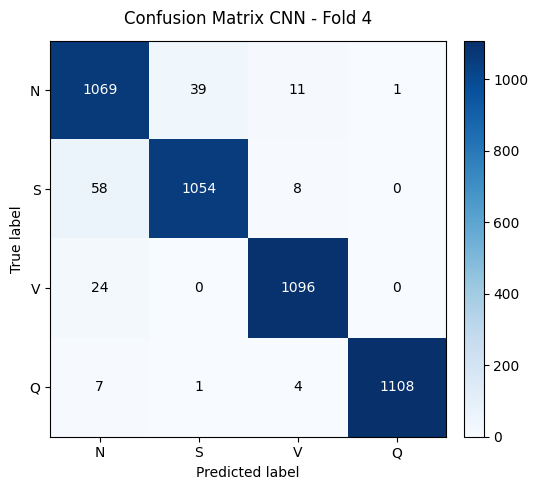

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Confusion matrix
cm = np.array([
    [1069,  39,  11,   1],  # True N
    [  58, 1054,  8,   0],  # True S
    [  24,   0, 1096,  0],  # True V
    [   7,   1,   4, 1108]  # True Q
], dtype=int)

classes = ['N', 'S', 'V', 'Q']

# Plot sederhana tanpa grid
fig, ax = plt.subplots(figsize=(5.5, 5))
im = ax.imshow(cm, cmap='Blues', interpolation='nearest')

ax.set_title('Confusion Matrix CNN - Fold 4', pad=12)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

# Colorbar
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Anotasi nilai di tiap sel
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f'{cm[i, j]}',
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black',
                fontsize=10)

plt.tight_layout()
plt.savefig('Confusion Matrix CNN - Fold 4.png', dpi=150, bbox_inches='tight')  # opsional
plt.show()


In [ ]:
EXTERNAL TEST

In [19]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


Evaluasi External Test Set (CNN): 100%|██████████| 88/88 [00:00<00:00, 612.94it/s]



=== Evaluasi pada External Test Set (CNN Baseline) ===
              precision    recall  f1-score   support

           N   0.802158  0.955714  0.872229      1400
           S   0.956757  0.758571  0.846215      1400
           V   0.956583  0.975714  0.966054      1400
           Q   0.998565  0.994286  0.996421      1400

    accuracy                       0.921071      5600
   macro avg   0.928516  0.921071  0.920230      5600
weighted avg   0.928516  0.921071  0.920230      5600



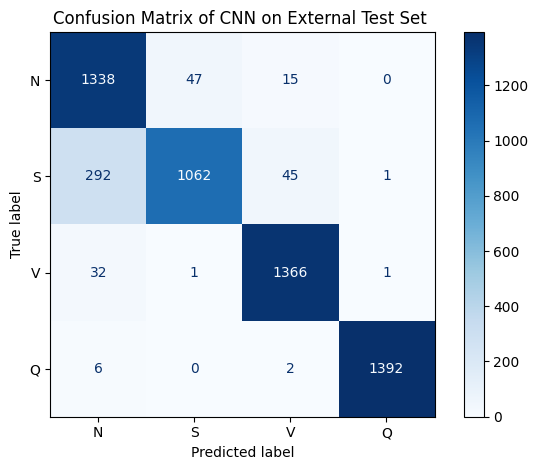

Confusion matrix disimpan ke: cnn_non_tuning_externaltest/confusion_matrix_external_cnn.png

=== Ringkasan Evaluasi (External Test Set) ===
Accuracy   : 0.921071
Precision  : 0.928516
Sensitivity: 0.921071
Specificity: 0.973690
F1-Score   : 0.920230

CSV disimpan:
- cnn_non_tuning_externaltest/external_summary_metrics.csv
- cnn_non_tuning_externaltest/external_per_class_metrics.csv
AUC Macro  : 0.989830
AUC Micro  : 0.992810

=== Evaluasi Kuantitatif Tambahan ===
Model Size        : 0.36 MB
Average Inference : 0.000008 detik/sample
CPU Memory Usage  : 3354.92 MB
GPU Memory Usage  : 0.00 MB


In [32]:
# External Test - CNN Baseline (GAF-only) [FIXED: same arch as training + strict load]
import os, time, numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, accuracy_score,
                             precision_score, recall_score, f1_score,
                             roc_auc_score)
from tqdm import tqdm
import pandas as pd

# ====== Config ======
BATCH_SIZE    = 64
NUM_CLASSES   = 4
CLASS_NAMES   = ['N', 'S', 'V', 'Q']
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

CKPT_PATH     = "cnn_non_tuning/cnn_fold4.pth"   # fold terbaik
X_IMG_PATH    = "gaf_images_test.npy"
Y_LABEL_PATH  = "y_test_final.npy"

OUT_DIR       = "cnn_non_tuning_externaltest"
os.makedirs(OUT_DIR, exist_ok=True)
SAVE_CM_PNG   = os.path.join(OUT_DIR, "confusion_matrix_external_cnn.png")
SAVE_REPORT   = os.path.join(OUT_DIR, "classification_report_external.txt")
SAVE_SUMMARY  = os.path.join(OUT_DIR, "external_summary_metrics.csv")
SAVE_PERCLS   = os.path.join(OUT_DIR, "external_per_class_metrics.csv")

# ====== Load External Test Set ======
X_image = np.load(X_IMG_PATH)  # (N,H,W) atau (N,1,H,W)
y_label = np.load(Y_LABEL_PATH)

# Samakan normalisasi dengan training: skala ke [0,1] bila di luar range
if X_image.max() > 1.0 or X_image.min() < 0.0:
    gmax, gmin = X_image.max(), X_image.min()
    if gmax != gmin:
        X_image = (X_image - gmin) / (gmax - gmin)

X_image_t = torch.tensor(X_image, dtype=torch.float32)
if X_image_t.ndim == 3:
    X_image_t = X_image_t.unsqueeze(1)  # (N,1,H,W)
elif X_image_t.ndim == 4 and X_image_t.size(1) in (1,3):
    pass
else:
    raise ValueError(f"Bentuk X_image tidak dikenali: {tuple(X_image_t.shape)}")

y_label_t = torch.tensor(y_label, dtype=torch.long)

test_ds     = TensorDataset(X_image_t, y_label_t)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# ====== Model: persis seperti training ======
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4, in_ch=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_ch, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 64->32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 32->16
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 16->8
        )
        self.gap = nn.AdaptiveAvgPool2d(1)  # -> (128,1,1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(128, num_classes)  # <<< hanya 1 FC (128 -> C)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# ====== Load checkpoint (STRICT) ======
in_channels = X_image_t.size(1)
model = SimpleCNN(num_classes=NUM_CLASSES, in_ch=in_channels).to(DEVICE)

if not os.path.exists(CKPT_PATH):
    raise FileNotFoundError(f"Checkpoint tidak ditemukan: {CKPT_PATH}")

state = torch.load(CKPT_PATH, map_location=DEVICE)
if isinstance(state, dict) and 'state_dict' in state:
    state = state['state_dict']
# bersihkan prefix 'module.' kalau ada
state = {k.replace("module.", ""): v for k, v in state.items()}
# Pakai strict=True agar ketahuan jika arsitektur beda
model.load_state_dict(state, strict=True)
model.eval()

# ====== Evaluate ======
all_preds, all_labels, all_logits = [], [], []
inference_times = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluasi External Test Set (CNN)"):
        imgs   = imgs.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)

        t0 = time.perf_counter()
        logits = model(imgs)
        t1 = time.perf_counter()

        preds = torch.argmax(logits, dim=1)

        all_logits.append(logits.cpu())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        inference_times.append((t1 - t0) / imgs.size(0))

all_logits = torch.cat(all_logits, dim=0)
y_probs = torch.softmax(all_logits, dim=1).numpy()
y_true  = np.array(all_labels)
y_pred  = np.array(all_preds)

# ====== Report & Confusion Matrix ======
report_txt = classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=6)
print("\n=== Evaluasi pada External Test Set (CNN Baseline) ===")
print(report_txt)
with open(SAVE_REPORT, "w") as f:
    f.write(report_txt)

ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=CLASS_NAMES, cmap="Blues", values_format="d"
)
plt.title("Confusion Matrix of CNN on External Test Set ")
plt.tight_layout()
plt.savefig(SAVE_CM_PNG, dpi=150)
plt.show()
print(f"Confusion matrix disimpan ke: {SAVE_CM_PNG}")

# ====== Ringkasan ======
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
rec  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1   = f1_score(y_true, y_pred, average="weighted", zero_division=0)

cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)
spec_per_cls = TN / (TN + FP + 1e-8)
spec_mean = spec_per_cls.mean()

print("\n=== Ringkasan Evaluasi (External Test Set) ===")
print(f"Accuracy   : {acc:.6f}")
print(f"Precision  : {prec:.6f}")
print(f"Sensitivity: {rec:.6f}")
print(f"Specificity: {spec_mean:.6f}")
print(f"F1-Score   : {f1:.6f}")

# simpan CSV
summary_df = pd.DataFrame([{
    "Accuracy": acc, "Precision": prec, "Sensitivity": rec,
    "Specificity": float(spec_mean), "F1-Score": f1,
    "AvgInference(s/sample)": float(np.mean(inference_times)) if inference_times else np.nan
}])
summary_df.to_csv(SAVE_SUMMARY, index=False)

percls_df = pd.DataFrame({
    "Class": CLASS_NAMES,
    "Precision": [precision_score(y_true, y_pred, labels=[i], average='macro', zero_division=0) for i in range(NUM_CLASSES)],
    "Sensitivity": [recall_score(y_true, y_pred, labels=[i], average='macro', zero_division=0) for i in range(NUM_CLASSES)],
    "Specificity": spec_per_cls,
    "F1-Score": [f1_score(y_true, y_pred, labels=[i], average='macro', zero_division=0) for i in range(NUM_CLASSES)]
})
percls_df.to_csv(SAVE_PERCLS, index=False)

print(f"\nCSV disimpan:\n- {SAVE_SUMMARY}\n- {SAVE_PERCLS}")

# ====== ROC-AUC ======
try:
    y_true_1hot = np.eye(NUM_CLASSES)[y_true]
    auc_macro   = roc_auc_score(y_true_1hot, y_probs, average='macro', multi_class='ovr')
    auc_micro   = roc_auc_score(y_true_1hot, y_probs, average='micro', multi_class='ovr')
    print(f"AUC Macro  : {auc_macro:.6f}")
    print(f"AUC Micro  : {auc_micro:.6f}")
except Exception as e:
    print("ROC AUC Calculation failed:", e)

# ====== Size & Memory ======
try:
    import psutil
    cpu_mem_mb = psutil.Process().memory_info().rss / 1024**2
except Exception:
    cpu_mem_mb = float('nan')

try:
    import GPUtil
    gpu_mem_mb = GPUtil.getGPUs()[0].memoryUsed if torch.cuda.is_available() else 0
except Exception:
    gpu_mem_mb = 0

param_size  = sum(p.numel() * p.element_size() for p in model.parameters())
buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
model_size_mb = (param_size + buffer_size) / 1024**2
avg_infer_time = float(np.mean(inference_times)) if len(inference_times) else float('nan')

print("\n=== Evaluasi Kuantitatif Tambahan ===")
print(f"Model Size        : {model_size_mb:.2f} MB")
print(f"Average Inference : {avg_infer_time:.6f} detik/sample")
print(f"CPU Memory Usage  : {cpu_mem_mb:.2f} MB")
if torch.cuda.is_available():
    print(f"GPU Memory Usage  : {gpu_mem_mb:.2f} MB")
